# A1 assignment's notebook for Complex Networks at URV 2025

## Authors:

- Lobo Santos, Antonio
-  Kasa, Andras


 ## Requirements and Constants
 This cell imports all the necessary libraries for data handling, numerical operations, plotting, and network analysis. 
 It also sets up important constant like Dataset Path.


In [7]:
# Requirements
import pandas as pd          # For dataframes and analysis
import numpy as np           # For numerical operations
import matplotlib.pyplot as plt  # For plotting
from matplotlib import rcParams
from matplotlib import colors
import random as random      # For randomness if needed
import networkx as nx        # For network tools
import os                    # For file management
from tabulate import tabulate # For table printing
import math                  # For mathematical operations
import itertools              # For iterations
from scipy import stats
from collections import Counter

DATASET_PATH = os.path.join("..","Datasets") # Path to the datasets folder

### Reading a Pajek (.net) File 
This cell defines a function `read_network` which takes a filepath to a Pajek file (with extension `.net`) and returns a NetworkX graph. Internally, it uses `nx.read_pajek` to read the network and then converts it to a simple `nx.Graph` (if the network is undirected)

In [34]:
def read_network(filepath):
    """
    Reads a network stored in Pajek (.net) format and returns a NetworkX graph.
    
    Parameters:
        filepath (str): Path to the .net file.
        
    Returns:
        G (nx.Graph or nx.DiGraph): The resulting network.
    """
    # Read the network using NetworkX's read_pajek function
    original_G = nx.read_pajek(filepath)
    
    # Check for self loops and print a warning with the count
    num_self_loops = sum(1 for u, v in original_G.edges() if u == v)
    if num_self_loops:
        print(f"Warning: {num_self_loops} self-loop(s) found.")
    else:
        print("No self loops found.")
    
    # Check for duplicated edges:
    # For undirected graphs, sort the nodes in the edge to ensure (u,v) and (v,u) are identical.
    edge_counts = {}
    for u, v in original_G.edges():
        key = (u, v) if original_G.is_directed() else tuple(sorted((u, v)))
        edge_counts[key] = edge_counts.get(key, 0) + 1

    # Count duplicates (each extra occurrence beyond the first is a duplicate)
    num_duplicates = sum(count - 1 for count in edge_counts.values() if count > 1)
    if num_duplicates:
        print(f"Warning: {num_duplicates} duplicated edge(s) found.")
    else:
        print("No duplicated edges found.")
    
    # Optionally, convert to a simple graph if you want to ignore parallel edges or self-loops.
    if original_G.is_directed():
        print("Graph is directed")
        G = nx.DiGraph(original_G)
    else:
        G = nx.Graph(original_G)
        
    return G

# Part 1: Structural characterization of networks

## Macroscopic Analysis

### Computing Network Metrics 
This cell defines a function `compute_network_metrics` that computes key macroscopic metrics of the network: - Number of nodes and edges - Minimum, maximum, and average degree - Average clustering coefficient - Degree assortativity coefficient - Average path length and network diameter (computed on the largest connected component if the graph is not connected) The results are returned as a pandas DataFrame.

In [35]:
def compute_network_metrics(G, graph_name):
    """
    Computes several network metrics and returns them in a pandas DataFrame.
    
    Metrics computed:
      - Number of nodes
      - Number of edges
      - Minimum degree, maximum degree, and average degree
      - Average clustering coefficient
      - Degree assortativity
      - Average path length (for largest connected component if the network is not connected)
      - Diameter (for largest connected component if the network is not connected)
    
    Parameters:
        G (nx.Graph or nx.DiGraph): The networkx graph.
        graph_name (str): The name of the graph to use as the index for the DataFrame.
        
    Returns:
        metrics_df (pd.DataFrame): DataFrame with the computed metrics.
    """
    # Basic metrics
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()
    degrees = [d for n, d in G.degree()]
    min_degree = np.min(degrees)
    max_degree = np.max(degrees)
    avg_degree = np.mean(degrees)
    
    # Average clustering coefficient
    avg_clustering = nx.average_clustering(G)
    
    # Degree assortativity
    assortativity = nx.degree_assortativity_coefficient(G)
    
    # For metrics that require connectivity (average path length and diameter),
    # we use the largest connected component if G is not connected.
    if nx.is_connected(G):
        avg_path_length = nx.average_shortest_path_length(G)
        diameter = nx.diameter(G)
    else:
        # Get the largest connected component
        largest_cc = max(nx.connected_components(G), key=len)
        subgraph = G.subgraph(largest_cc)
        avg_path_length = nx.average_shortest_path_length(subgraph)
        diameter = nx.diameter(subgraph)
    
    # Compile the metrics into a dictionary
    metrics = {
        "Number of Nodes": [num_nodes],
        "Number of Edges": [num_edges],
        "Min Degree": [min_degree],
        "Max Degree": [max_degree],
        "Average Degree": [avg_degree],
        "Average Clustering Coefficient": [avg_clustering],
        "Degree Assortativity": [assortativity],
        "Average Path Length": [avg_path_length],
        "Diameter": [diameter]
    }
    
    # Create a DataFrame from the dictionary and set the index to the provided graph name
    metrics_df = pd.DataFrame(metrics, index=[graph_name])
    
    return metrics_df


### Plotting Degree Distribution Histograms 
This function, `plot_degree_distributions`, accepts a parameter `plot_type` that determines the visualization mode: - **'both'**: Displays a single figure with two subplots—one for the linear histogram and one for the log-log histogram. - **'linear'**: Displays only the linear scale histogram in a larger, standalone plot. - **'loglog'**: Displays only the log-log histogram in a larger, standalone plot. This flexibility allows the user to choose between a combined view or a more detailed focus on one of the visualizations.
Based on both visualizations authors decide a specific one for each of the networks provided.

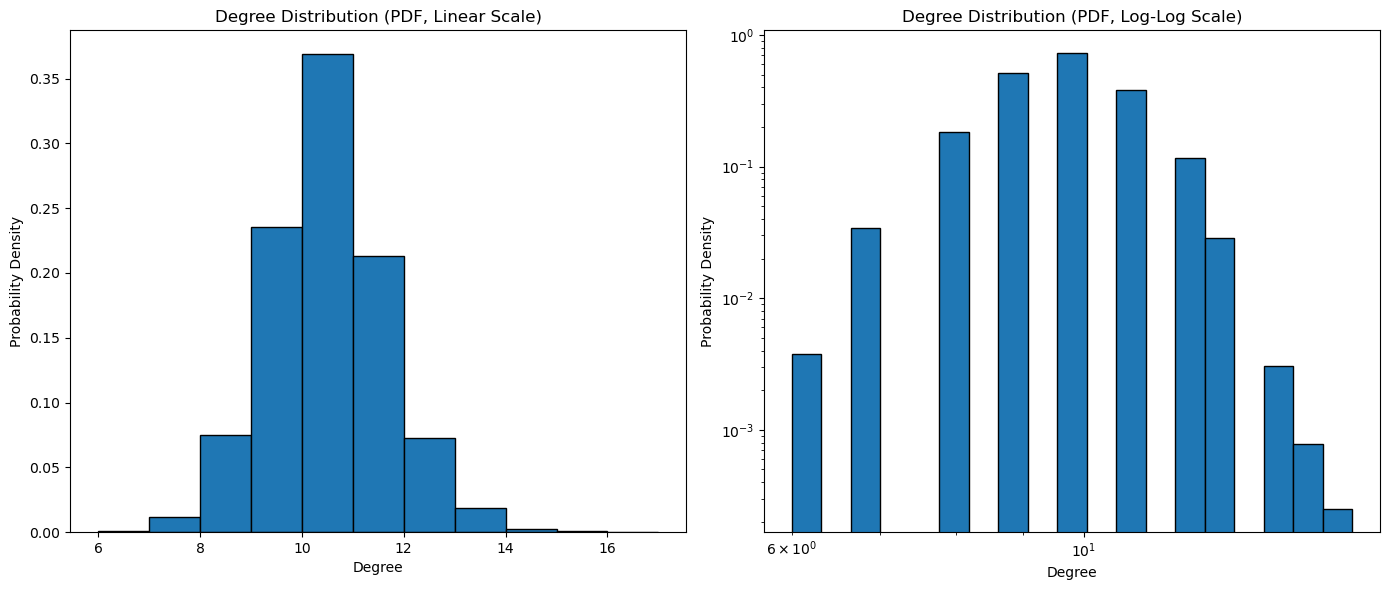

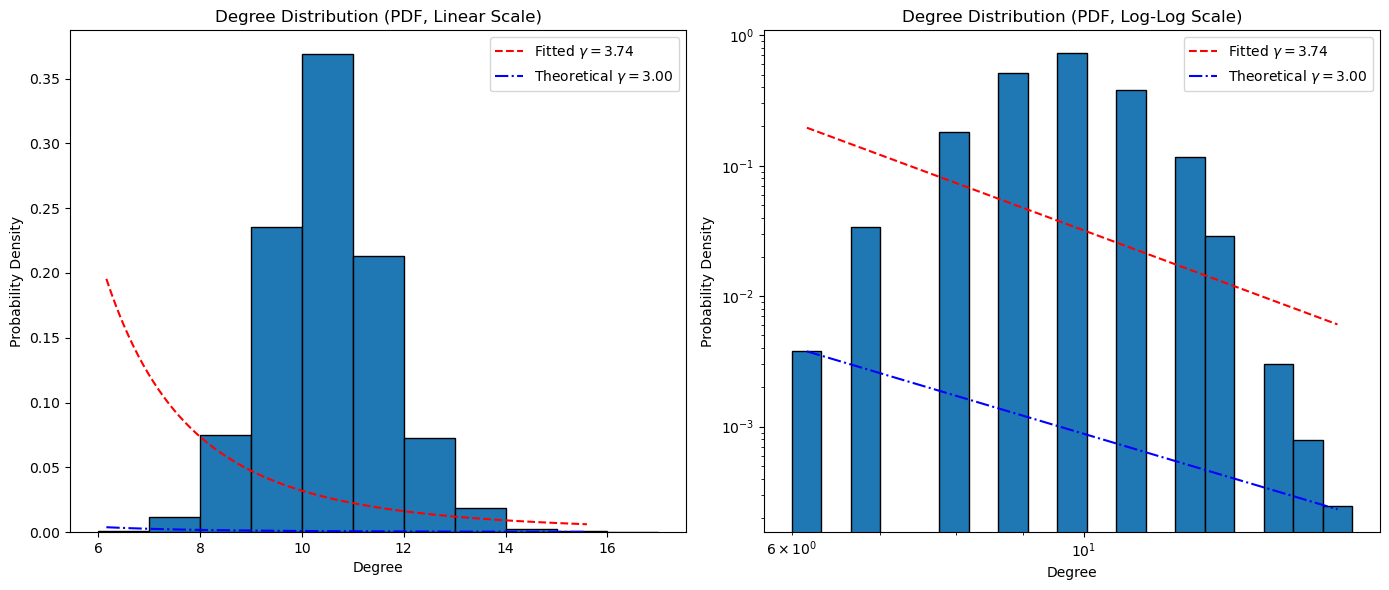

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

def analyze_network_macroscopic(filepath, graph_name, use_cdf=False, gamma=None, theoretical_gamma=3):
    
    # Read the network
    G = read_network(filepath)
    
    # Compute network metrics
    metrics_df = compute_network_metrics(G, graph_name)
    print(metrics_df)
    
    # Plot degree distributions using the passed theoretical_gamma parameter.
    plot_degree_distributions(G, plot_type='both', use_cdf=use_cdf, gamma=gamma, theoretical_gamma=theoretical_gamma)
    
    return metrics_df


def plot_degree_distributions(G, plot_type='both', use_cdf=False, gamma=False, theoretical_gamma=3.0):

    # Get the degree of each node.
    degrees = [d for _, d in G.degree()]

    # Define linear bins (from min degree to max degree + 1)
    k_min = min(degrees)
    k_max = max(degrees)
    linear_bins = range(k_min, k_max + 2)

    # Define logarithmic bins for the log-log histogram (avoid log(0))
    num_log_bins = 20
    log_bins = np.logspace(np.log10(max(k_min, 1)), np.log10(k_max), num=num_log_bins)

    # Set titles and labels based on PDF vs. CCDF.
    if use_cdf:
        # For CCDF we show the fraction of nodes with degree >= k.
        hist_title_linear = "Degree CCDF (Linear Scale)"
        hist_title_loglog = "Degree CCDF (Log-Log Scale)"
        y_label = "CCDF"
    else:
        hist_title_linear = "Degree Distribution (PDF, Linear Scale)"
        hist_title_loglog = "Degree Distribution (PDF, Log-Log Scale)"
        y_label = "Probability Density"

    def fit_power_law(deg_array, bins, use_cdf_flag):
        """
        Computes the binned "graphical heights" and then applies a linear regression
        in log-log space using np.polyfit.

        For PDF: the heights are computed as density = counts / (N * bin_width).
        For CCDF: the heights are computed as the cumulative probability (counts/total).

        Returns:
            gamma_est (float): Estimated exponent (for PDF, expect P(k) ~ k^(-γ);
                               for CCDF, expect CCDF ~ k^(1-γ) so that γ_est = 1 - slope).
            k_plot (np.array): k values for a smooth fitted curve.
            p_plot (np.array): Fitted curve values.
        """
        N = float(len(deg_array))
        # Compute histogram counts with density=False.
        counts, bin_edges = np.histogram(deg_array, bins=bins, density=False)
        bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
        
        if not use_cdf_flag:
            # PDF: convert counts to density by dividing by total and bin width.
            bin_widths = np.diff(bin_edges)
            heights = counts / (N * bin_widths)
        else:
            # CCDF: manually compute the cumulative counts (reverse cumulative sum)
            counts = np.cumsum(counts[::-1])[::-1]
            heights = counts / N

        # Use only valid points (positive k and positive height) for log-log polyfit.
        valid = (bin_centers > 0) & (heights > 0)
        k_valid = bin_centers[valid]
        h_valid = heights[valid]

        # Apply linear regression in log-log space.
        slope, intercept = np.polyfit(np.log(k_valid), np.log(h_valid), 1)
        # For PDF: we expect log(h) = -γ log(k) + const so that γ = -slope.
        # For CCDF: we expect log(h) = (1-γ) log(k) + const so that γ = 1 - slope.
        gamma_est = -slope if not use_cdf_flag else 1 - slope

        # Generate a smooth curve over the range of valid k.
        k_plot = np.logspace(np.log10(k_valid.min()), np.log10(k_valid.max()), 200)
        p_plot = np.exp(intercept) * k_plot**(slope)
        return gamma_est, k_plot, p_plot

    def fixed_power_law_line(deg_array, bins, use_cdf_flag, gamma_fixed):
        """
        Computes a theoretical power-law curve with exponent gamma_fixed.

        For PDF: P(k) ~ k^(-gamma_fixed).
        For CCDF: CCDF ~ k^(1-gamma_fixed).

        The scaling is chosen so that the curve passes through the first valid bin.
        Returns:
            k_plot (np.array): k values for the curve.
            p_plot (np.array): Theoretical curve values.
        """
        N = float(len(deg_array))
        counts, bin_edges = np.histogram(deg_array, bins=bins, density=False)
        bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
        
        if not use_cdf_flag:
            bin_widths = np.diff(bin_edges)
            heights = counts / (N * bin_widths)
        else:
            counts = np.cumsum(counts[::-1])[::-1]
            heights = counts / N

        valid = (bin_centers > 0) & (heights > 0)
        k_valid = bin_centers[valid]
        h_valid = heights[valid]

        # Use the first valid bin as the reference.
        k_ref = k_valid[0]
        h_ref = h_valid[0]
        if not use_cdf_flag:
            # For PDF: choose constant c so that c * k_ref^(-gamma_fixed) = h_ref.
            c = h_ref * (k_ref**gamma_fixed)
            exponent = -gamma_fixed
        else:
            # For CCDF: we want c * k_ref^(1-gamma_fixed) = h_ref.
            c = h_ref * (k_ref**(gamma_fixed - 1))
            exponent = 1 - gamma_fixed

        k_plot = np.logspace(np.log10(k_valid.min()), np.log10(k_valid.max()), 200)
        p_plot = c * k_plot**(exponent)
        return k_plot, p_plot

    # -------------------------------
    # PLOTTING
    # -------------------------------
    if plot_type == 'both':
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        # Linear scale histogram.
        axes[0].hist(degrees, bins=linear_bins, edgecolor='black', density=True,
                     cumulative=(False if not use_cdf else True))
        axes[0].set_title(hist_title_linear)
        axes[0].set_xlabel("Degree")
        axes[0].set_ylabel(y_label)
        # Log-log histogram.
        axes[1].hist(degrees, bins=log_bins, edgecolor='black', density=True,
                     cumulative=(False if not use_cdf else True))
        axes[1].set_xscale("log")
        axes[1].set_yscale("log")
        axes[1].set_title(hist_title_loglog)
        axes[1].set_xlabel("Degree")
        axes[1].set_ylabel(y_label)

        if gamma:
            # Compute fitted curve using polyfit over the graphical heights.
            gamma_est, k_plot_fit, p_plot_fit = fit_power_law(degrees, log_bins, use_cdf)
            # Compute fixed theoretical line with the given theoretical_gamma.
            k_plot_theo, p_plot_theo = fixed_power_law_line(degrees, log_bins, use_cdf, theoretical_gamma)
            # Overlay both curves on each subplot.
            axes[0].plot(k_plot_fit, p_plot_fit, 'r--', label=r'Fitted $\gamma = %.2f$' % gamma_est)
            axes[0].plot(k_plot_theo, p_plot_theo, 'b-.', label=r'Theoretical $\gamma = %.2f$' % theoretical_gamma)
            axes[0].legend()
            axes[1].plot(k_plot_fit, p_plot_fit, 'r--', label=r'Fitted $\gamma = %.2f$' % gamma_est)
            axes[1].plot(k_plot_theo, p_plot_theo, 'b-.', label=r'Theoretical $\gamma = %.2f$' % theoretical_gamma)
            axes[1].legend()
        plt.tight_layout()
        plt.show()

    elif plot_type == 'linear':
        plt.figure(figsize=(8, 6))
        plt.hist(degrees, bins=linear_bins, edgecolor='black', density=True,
                 cumulative=(False if not use_cdf else True))
        plt.title(hist_title_linear)
        plt.xlabel("Degree")
        plt.ylabel(y_label)
        if gamma:
            gamma_est, k_plot_fit, p_plot_fit = fit_power_law(degrees, log_bins, use_cdf)
            k_plot_theo, p_plot_theo = fixed_power_law_line(degrees, log_bins, use_cdf, theoretical_gamma)
            plt.plot(k_plot_fit, p_plot_fit, 'r--', label=r'Fitted $\gamma = %.2f$' % gamma_est)
            plt.plot(k_plot_theo, p_plot_theo, 'b-.', label=r'Theoretical $\gamma = %.2f$' % theoretical_gamma)
            plt.legend()
        plt.tight_layout()
        plt.show()

    elif plot_type == 'loglog':
        plt.figure(figsize=(8, 6))
        plt.hist(degrees, bins=log_bins, edgecolor='black', density=True,
                 cumulative=(False if not use_cdf else True))
        plt.xscale("log")
        plt.yscale("log")
        plt.title(hist_title_loglog)
        plt.xlabel("Degree")
        plt.ylabel(y_label)
        if gamma:
            gamma_est, k_plot_fit, p_plot_fit = fit_power_law(degrees, log_bins, use_cdf)
            k_plot_theo, p_plot_theo = fixed_power_law_line(degrees, log_bins, use_cdf, theoretical_gamma)
            plt.plot(k_plot_fit, p_plot_fit, 'r--', label=r'Fitted $\gamma = %.2f$' % gamma_est)
            plt.plot(k_plot_theo, p_plot_theo, 'b-.', label=r'Theoretical $\gamma = %.2f$' % theoretical_gamma)
            plt.legend()
        plt.tight_layout()
        plt.show()

    else:
        raise ValueError("Invalid plot_type. Choose 'both', 'linear', or 'loglog'.")



# # For both histograms in one figure:
plot_degree_distributions(G, plot_type='both')
# #
# # For a larger linear histogram:
# plot_degree_distributions(G, plot_type='linear')
# #
# # For a larger log-log histogram:
# plot_degree_distributions(G, plot_type='loglog')
# # For both histograms in one figure, but using CCDF instead of PDF:
plot_degree_distributions(G, plot_type='both', use_cdf=False, gamma=True)


### Putting Everything Together:
In this section we will use previously defined functions to obtain and interpret the results of network 1 to 4.
With this purpose we create a function `analyze_network_macroscopic` that receives a name and computes and print all the macroscopic metrics.
These results will be discussed in `Assignment1_report.pdf`

In [5]:
def analyze_network_macroscopic(filepath, graph_name, use_cdf=False, gamma=None, theoretical_gamma=3):
    """
    Analyzes the macroscopic properties of a network by reading the network,
    computing metrics, and plotting degree distribution histograms.
    
    Parameters:
        filepath (str): Path to the .net file.
        graph_name (str): The name of the graph to use for labeling.
        use_cdf (bool): If True, plots the CCDF instead of the PDF.
        gamma (bool): If True, overlays fitted and theoretical power-law curves.
        theoretical_gamma (float): The theoretical gamma value for the reference curve.
        
    Returns:
        metrics_df (pd.DataFrame): DataFrame with the computed metrics.
    """
    # Read the network
    G = read_network(filepath)
    
    # Compute network metrics
    metrics_df = compute_network_metrics(G, graph_name)
    print(metrics_df)
    
    # Plot degree distributions using the passed theoretical_gamma parameter.
    plot_degree_distributions(G, plot_type='both', use_cdf=use_cdf, gamma=gamma, theoretical_gamma=theoretical_gamma)
    
    return metrics_df


#### Network 1:

In [13]:
def check_er_poisson(G, plot=True):
    """
    Check if a network's degree distribution follows a Poisson distribution
    as expected for an Erdős-Rényi random graph model.
    
    Parameters:
        G (networkx.Graph): Input graph
        plot (bool): Whether to create a visualization
        
    Returns:
        dict: Dictionary with test results
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy import stats
    from collections import Counter
    
    # Get degree sequence from the graph
    degrees = [d for _, d in G.degree()]
    avg_degree = np.mean(degrees)
    
    # Count occurrences of each degree
    degree_counts = Counter(degrees)
    
    # Get degrees and their frequencies
    observed_degrees = sorted(degree_counts.keys())
    observed_counts = [degree_counts[d] for d in observed_degrees]
    
    # Calculate expected counts based on Poisson distribution
    n = len(degrees)
    expected_probs = [stats.poisson.pmf(d, avg_degree) for d in observed_degrees]
    
    # Normalize expected_probs to ensure sums match
    expected_counts = [n * prob / sum(expected_probs) for prob in expected_probs]
    
    # Chi-square test
    chi2, p_value = stats.chisquare(observed_counts, expected_counts)
    
    # Plot if requested
    if plot:
        plt.figure(figsize=(10, 6))
        
        # Plot observed distribution
        plt.bar(observed_degrees, [count/n for count in observed_counts], 
                alpha=0.5, label='Observed')
        
        # Plot Poisson distribution
        x = np.arange(0, max(observed_degrees)+1)
        poisson_probs = stats.poisson.pmf(x, avg_degree)
        # Normalize for plotting
        poisson_probs = poisson_probs / sum(poisson_probs) * sum([count/n for count in observed_counts])
        plt.plot(x, poisson_probs, 'r-', marker='o', label='Poisson')
        
        plt.xlabel('Degree (k)')
        plt.ylabel('Probability P(k)')
        plt.title(f'Degree Distribution vs. Poisson (λ={avg_degree:.2f})\n' +
                  f'p-value: {p_value:.6f} ' +
                  f'({"Consistent with ER model" if p_value > 0.05 else "Not consistent with ER model"})')
        plt.legend()
        plt.grid(alpha=0.3)
        plt.tight_layout()
    
    # Return results
    return {
        'chi2': chi2,
        'p_value': p_value,
        'is_poisson': p_value > 0.05,
        'avg_degree': avg_degree
    }

No self loops found.
No duplicated edges found.
No self loops found.
No duplicated edges found.
           Number of Nodes  Number of Edges  Min Degree  Max Degree  \
network 1             5000            25000           6          16   

           Average Degree  Average Clustering Coefficient  \
network 1            10.0                         0.41407   

           Degree Assortativity  Average Path Length  Diameter  
network 1             -0.009733             5.121125         8  


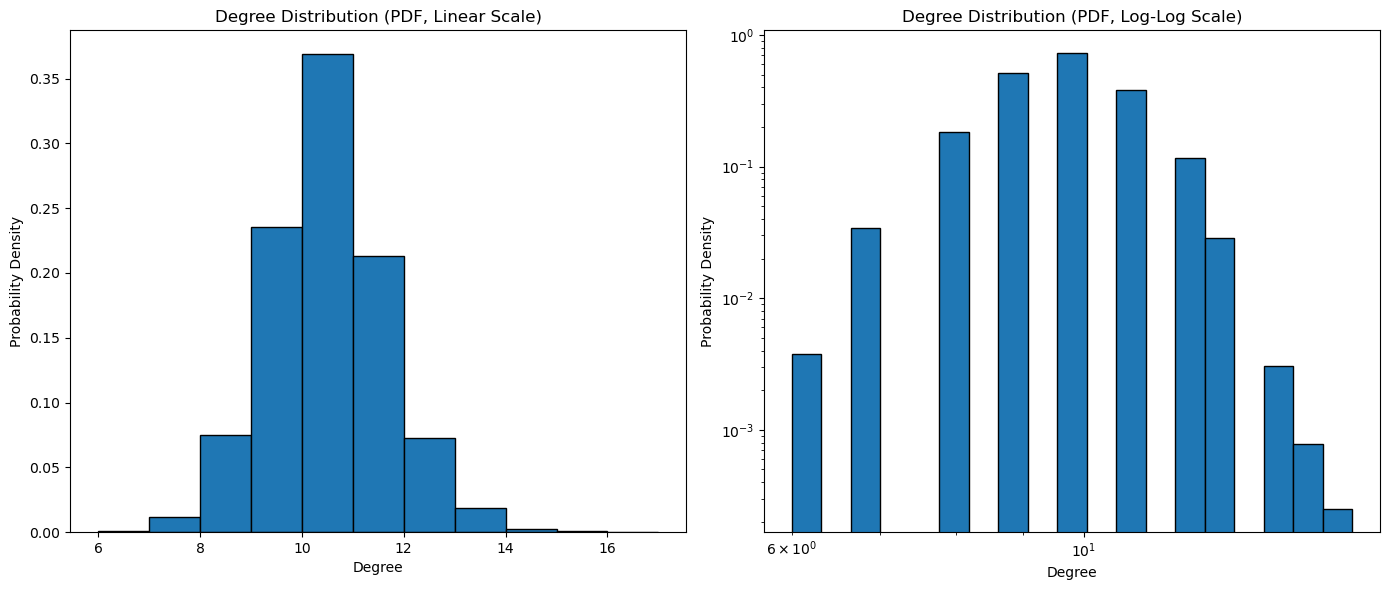

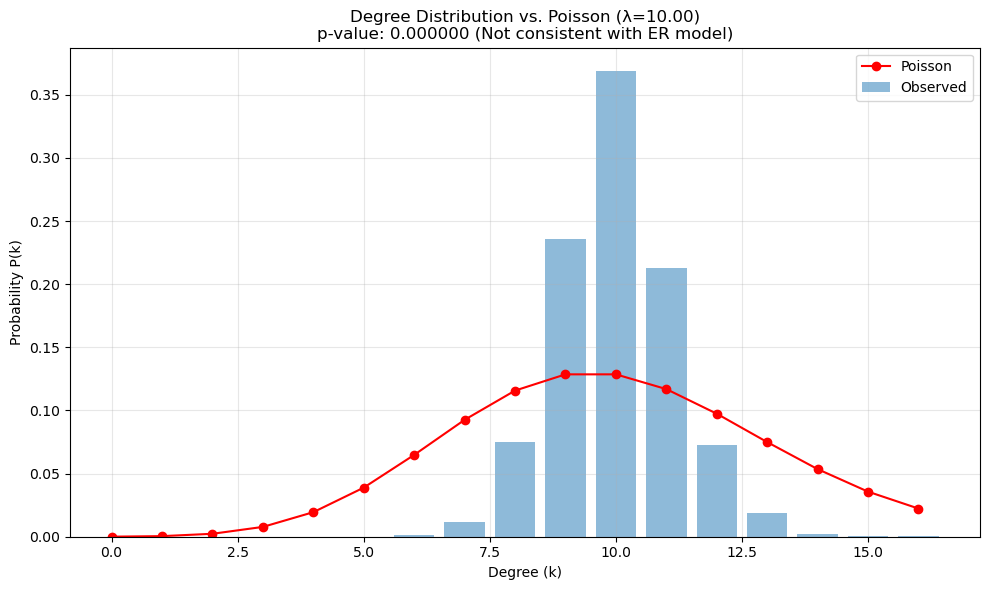

In [37]:
network1_path = os.path.join(DATASET_PATH, "net1.net")
G = read_network(network_path)
metrics_df1 = analyze_network_macroscopic(network1_path, "network 1")
metrics_df1

# Check if it follows an Erdős-Rényi model
result = check_er_poisson(G)

Check the basic features of ER: 

#### Network 2:

No self loops found.
No duplicated edges found.
           Number of Nodes  Number of Edges  Min Degree  Max Degree  \
network 2             5000            24873           1          24   

           Average Degree  Average Clustering Coefficient  \
network 2          9.9492                        0.002099   

           Degree Assortativity  Average Path Length  Diameter  
network 2             -0.005663              3.95605         7  


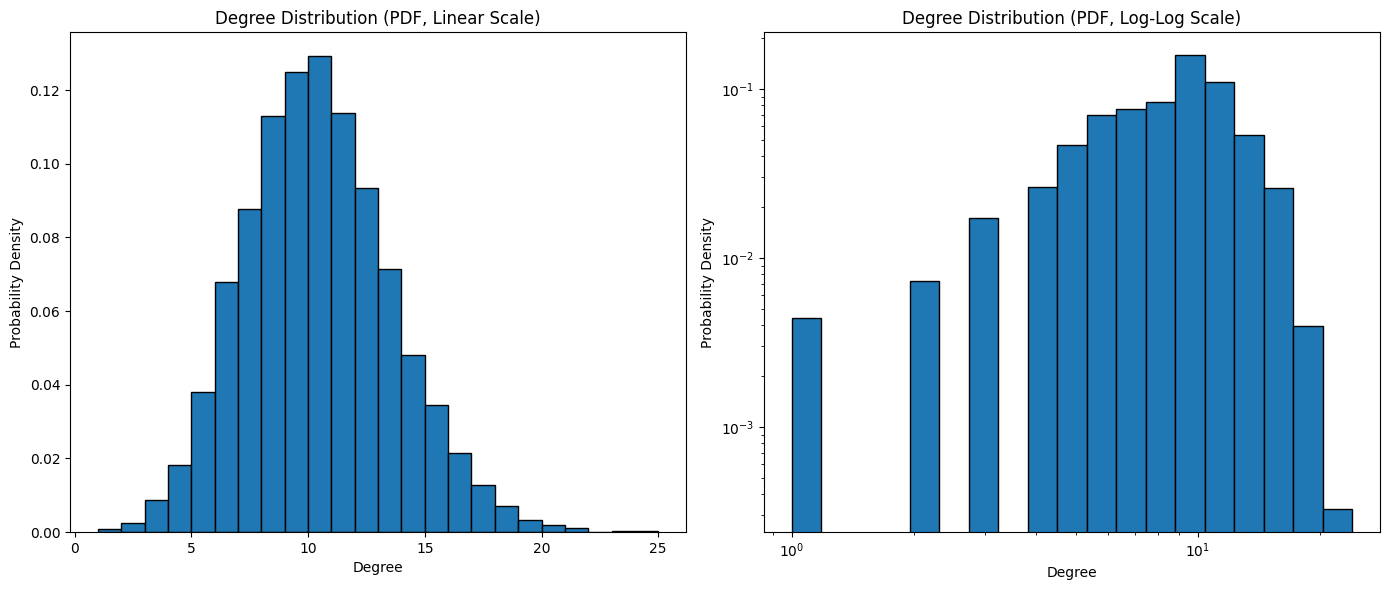

,Number of Nodes,Number of Edges,Min Degree,Max Degree,Average Degree,Average Clustering Coefficient,Degree Assortativity,Average Path Length,Diameter
network 2,5000,24873,1,24,9.9492,0.002099,-0.005663,3.95605,7


In [49]:
network2_path = os.path.join(DATASET_PATH, "net2.net")
metrics_df2 = analyze_network_macroscopic(network2_path, "network 2")
metrics_df2

No self loops found.
No duplicated edges found.


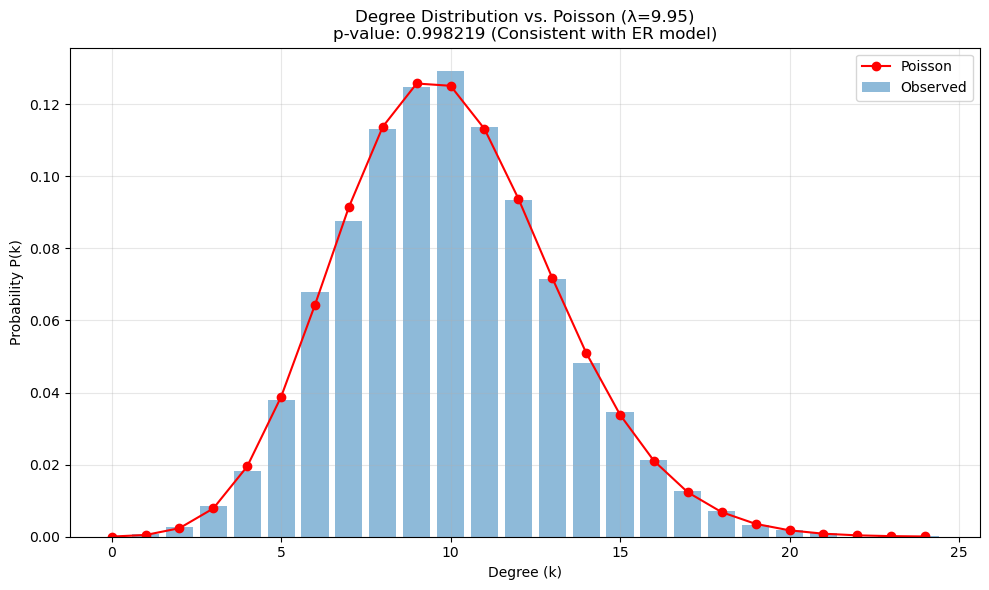

In [15]:
network_path2 = os.path.join(DATASET_PATH, "net2.net")
G2 = read_network(network_path2)

# Check if it follows an Erdős-Rényi model
result = check_er_poisson(G2)

#### Network 3:

No duplicated edges found.
           Number of Nodes  Number of Edges  Min Degree  Max Degree  \
network 3             5000            23508           3         732   

           Average Degree  Average Clustering Coefficient  \
network 3          9.4032                        0.086214   

           Degree Assortativity  Average Path Length  Diameter  
network 3              -0.13386             3.008243         5  


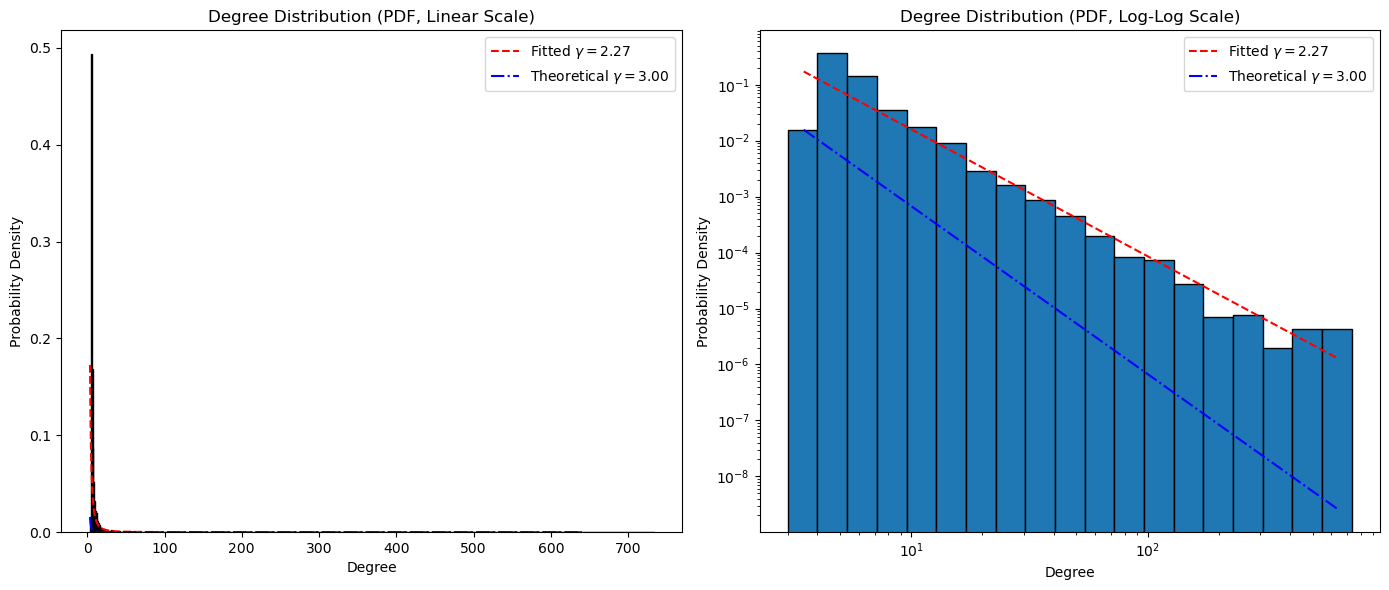

,Number of Nodes,Number of Edges,Min Degree,Max Degree,Average Degree,Average Clustering Coefficient,Degree Assortativity,Average Path Length,Diameter
network 3,5000,23508,3,732,9.4032,0.086214,-0.13386,3.008243,5


In [19]:
network3_path = os.path.join(DATASET_PATH, "net3.net")
metrics_df3 = analyze_network_macroscopic(network3_path, "network 3",gamma=True)
metrics_df3

No duplicated edges found.


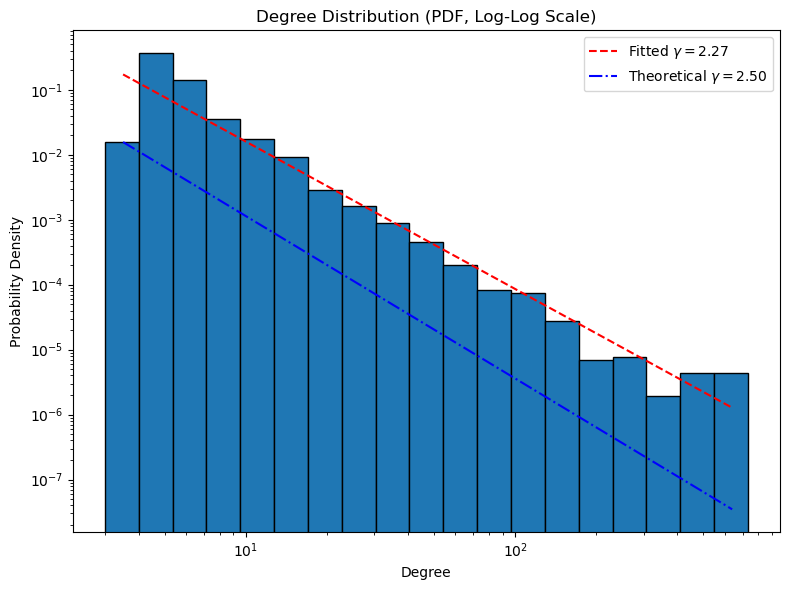

In [21]:
G3 = read_network(network3_path)
plot_degree_distributions(G3, plot_type='loglog',use_cdf=False,gamma=True, theoretical_gamma=2.5)

In [27]:
def represent_degree_distribution(G,scale='linear',rep='bars'):
    degree_sequence=[G.degree(node) for node in G.nodes()]
    from collections import Counter

    degree_counts = Counter(degree_sequence)
    min_degree=min(degree_sequence)
    max_degree=max(degree_sequence)

    degrees=list(degree_counts.keys())
    degree_count=list(degree_counts.values())

    fig,ax=plt.subplots(1,1,figsize=(5,5))
    if rep=='bars':
        ax.bar(degrees,degree_count)
    if rep=='scatter':
        ax.scatter(degrees,degree_count)
    
    if scale=='log':
        ax.set_xscale('log')
        ax.set_yscale('log')
    ax.set_xlabel('Degree',fontsize=15)
    ax.set_ylabel('#nodes',fontsize=15)
    ax.tick_params(which='major',axis='both',labelsize=15)  
    
def check_configuration_model(G, plot=True):

    # Get degree sequence
    degrees = dict(G.degree())
    degree_seq = list(degrees.values())
    
    # Calculate key statistics
    n_nodes = G.number_of_nodes()
    n_edges = G.number_of_edges()
    
    # Calculate average degree and second moment
    avg_k = np.mean(degree_seq)
    avg_k_squared = np.mean([d*d for d in degree_seq])
    
    # Expected number of self-loops in configuration model
    expected_self_loops = (1/(2*n_nodes)) * (avg_k_squared - avg_k)/avg_k
    
    # Expected fraction of multi-edges
    expected_multi_edges = (1/(2*n_nodes)) * ((avg_k_squared - avg_k)/avg_k)**2
    
    # Calculate observed connections vs expected by degree products
    edge_probs = {}
    observed_connections = {}
    
    # Sample a subset of possible node pairs for efficiency
    sampled_pairs = []
    all_nodes = list(G.nodes())
    
    # Include all actual edges
    for u, v in G.edges():
        sampled_pairs.append((u, v))
    
    # Add some non-connected pairs
    import random
    random.seed(42)
    non_edges = list(nx.non_edges(G))
    if len(non_edges) > 1000:  # Limit the number of non-edges to check
        non_edges = random.sample(non_edges, 1000)
    
    sampled_pairs.extend(non_edges)
    
    # For each sampled pair, calculate expected probability and check if connected
    for u, v in sampled_pairs:
        # Expected probability based on configuration model
        p_uv = (degrees[u] * degrees[v]) / (2 * n_edges)
        
        # Round to handle floating point
        p_uv_rounded = round(p_uv * 100) / 100
        
        # Initialize counter if needed
        if p_uv_rounded not in edge_probs:
            edge_probs[p_uv_rounded] = 0
            observed_connections[p_uv_rounded] = 0
        
        # Count the expected probability
        edge_probs[p_uv_rounded] += 1
        
        # Check if actually connected
        if G.has_edge(u, v):
            observed_connections[p_uv_rounded] += 1
    
    # Calculate connection ratio for each probability bin
    connection_ratios = {}
    for p in edge_probs:
        if edge_probs[p] > 0:
            connection_ratios[p] = observed_connections[p] / edge_probs[p]
        else:
            connection_ratios[p] = 0
    
    # Plot if requested
    if plot:
        plt.figure(figsize=(10, 6))
        
        # Prepare data for plotting
        probs = sorted(connection_ratios.keys())
        ratios = [connection_ratios[p] for p in probs]
        
        # Plot the actual connection ratio vs expected probability
        plt.scatter(probs, ratios, alpha=0.7)
        
        # Plot the ideal line (y=x)
        ideal_x = np.linspace(0, max(probs), 100)
        plt.plot(ideal_x, ideal_x, 'r-', label='Ideal configuration model')
        
        plt.xlabel('Expected connection probability (k_i * k_j / 2E)')
        plt.ylabel('Observed connection ratio')
        plt.title('Configuration Model Test: Expected vs. Observed Connections')
        plt.legend()
        plt.grid(alpha=0.3)
        
        # Add annotation with statistics
        plt.figtext(0.02, 0.02, 
                  f"Avg degree: {avg_k:.2f}\n"
                  f"Avg degree²: {avg_k_squared:.2f}\n"
                  f"Expected self-loops: {expected_self_loops:.6f}\n"
                  f"Expected multi-edges: {expected_multi_edges:.6f}",
                  bbox=dict(facecolor='white', alpha=0.8))
        
        plt.tight_layout()
    
    # Calculate goodness of fit using correlation between expected and observed
    # Only include probability bins with enough samples
    valid_probs = [p for p in probs if edge_probs[p] >= 5]
    valid_ratios = [connection_ratios[p] for p in valid_probs]
    
    correlation = np.corrcoef(valid_probs, valid_ratios)[0, 1] if len(valid_probs) > 1 else 0
    
    # Determine if it follows configuration model
    # A configuration model should have high correlation between expected and observed
    is_configuration = correlation > 0.85
    
    return {
        'avg_degree': avg_k,
        'avg_degree_squared': avg_k_squared,
        'expected_self_loops': expected_self_loops,
        'expected_multi_edges': expected_multi_edges,
        'correlation': correlation,
        'is_configuration_model': is_configuration,
        'connection_ratios': connection_ratios
    }


def check_barabasi_albert(G, plot=True):
    """
    Test if a network follows the Barabási-Albert preferential attachment model
    by checking if its degree distribution follows a power law.
    
    Parameters:
        G (networkx.Graph): Input graph
        plot (bool): Whether to create visualizations
        
    Returns:
        dict: Dictionary with test results
    """
    # Get degree sequence
    degrees = [d for _, d in G.degree()]
    degree_counts = Counter(degrees)
    
    # Filter out degrees with zero occurrences
    unique_degrees = sorted(degree_counts.keys())
    degree_freq = np.array([degree_counts[d] for d in unique_degrees])
    degree_prob = degree_freq / sum(degree_freq)
    
    # Prepare for power law fit
    # Remove zeros for log-log plot
    nonzero_idx = np.where(degree_prob > 0)[0]
    fit_degrees = np.array(unique_degrees)[nonzero_idx]
    fit_probs = degree_prob[nonzero_idx]
    
    # Perform power law fit on log-log scale
    log_degrees = np.log(fit_degrees)
    log_probs = np.log(fit_probs)
    
    # Linear regression for power law exponent
    slope, intercept, r_value, p_value, std_err = stats.linregress(log_degrees, log_probs)
    
    # Power law exponent is the negative of the slope
    gamma = -slope
    
    # Theoretical power law fit
    x_fit = np.logspace(np.log10(min(fit_degrees)), np.log10(max(fit_degrees)), 100)
    y_fit = np.exp(intercept) * x_fit**slope
    
    # Theoretical BA model with gamma = 3
    y_theoretical = min(fit_probs) * (min(fit_degrees)/x_fit)**3
    
    # Normalize theoretical curve to match observed data scale
    scaling_factor = fit_probs[0] / y_theoretical[0]
    y_theoretical *= scaling_factor
    
    # Calculate goodness of fit (R²)
    r_squared = r_value**2
    
    # Check if degree distribution follows power law (R² > 0.8 and 2 < gamma < 3.5)
    is_power_law = r_squared > 0.8 and 2 < gamma < 3.5
    
    # Plot if requested
    if plot:
        # Create figure with two subplots (linear and log-log)
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        
        # Linear scale plot
        ax1.bar(unique_degrees, degree_prob, width=0.8, alpha=0.7)
        ax1.set_xlabel('Degree (k)')
        ax1.set_ylabel('Probability Density')
        ax1.set_title('Degree Distribution (PDF, Linear Scale)')
        
        # Add theoretical curves to linear plot
        ax1.plot(x_fit, y_fit, 'r--', label=f'Fitted γ={gamma:.2f}')
        ax1.plot(x_fit, y_theoretical, 'b-.', label=f'Theoretical γ=3.00')
        ax1.legend()
        
        # Log-log scale plot
        ax2.bar(unique_degrees, degree_prob, width=0.8, alpha=0.7)
        ax2.set_xscale('log')
        ax2.set_yscale('log')
        ax2.set_xlabel('Degree (k)')
        ax2.set_ylabel('Probability Density')
        ax2.set_title('Degree Distribution (PDF, Log-Log Scale)')
        
        # Add theoretical curves to log-log plot
        ax2.plot(x_fit, y_fit, 'r--', label=f'Fitted γ={gamma:.2f}')
        ax2.plot(x_fit, y_theoretical, 'b-.', label=f'Theoretical γ=3.00')
        ax2.legend()
        
        # Adjust layout and display
        plt.tight_layout()
    
    # Return results
    return {
        'gamma': gamma,
        'r_squared': r_squared,
        'is_power_law': is_power_law,
        'is_ba_model': abs(gamma - 3) < 0.5 and is_power_law,
        'p_value': p_value,
        'std_err': std_err
    }



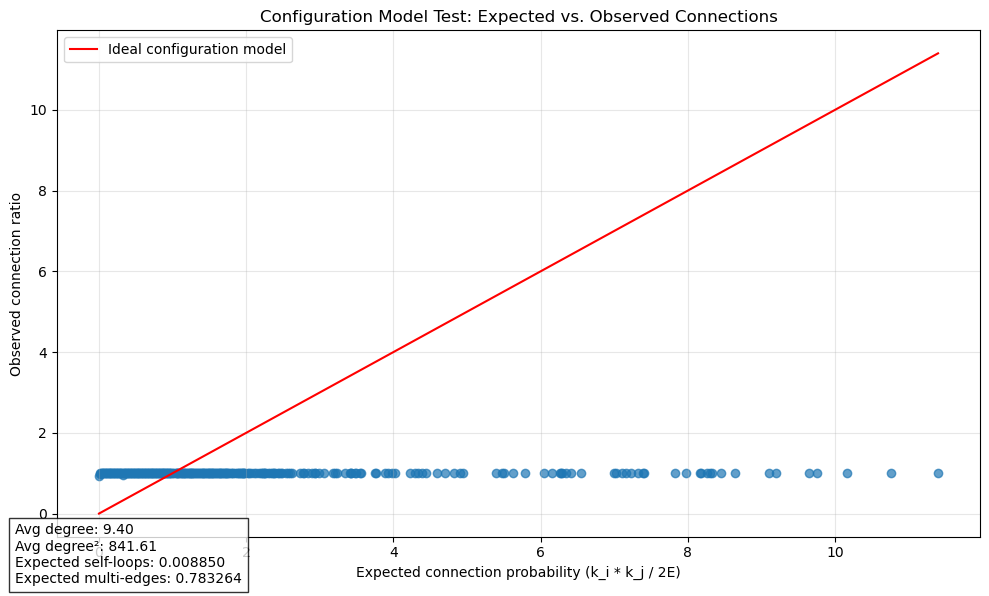

In [23]:
result_net3_cm = check_configuration_model(G3, plot=True)

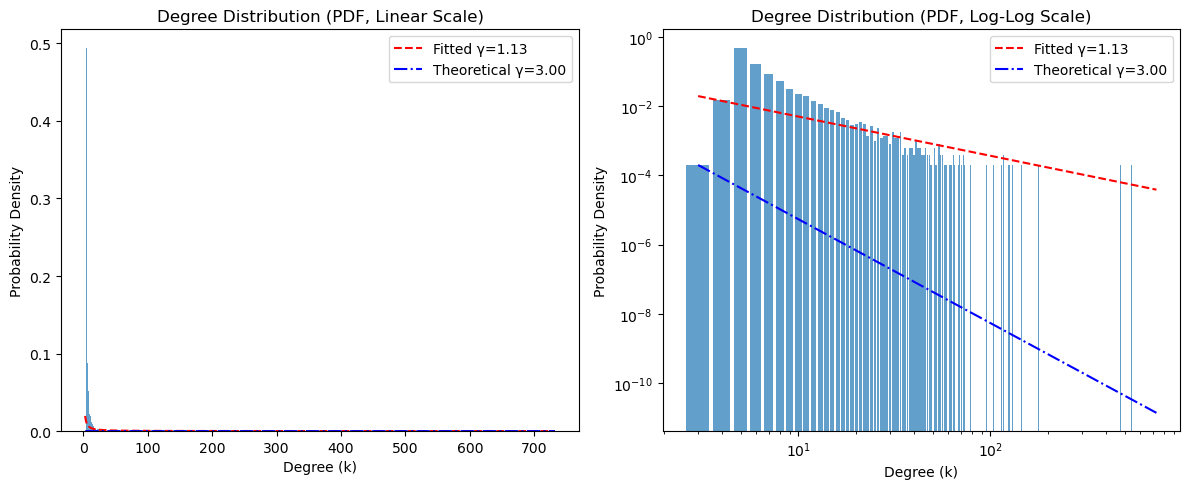

In [29]:
result_net3_BA = check_barabasi_albert (G3, plot=True)

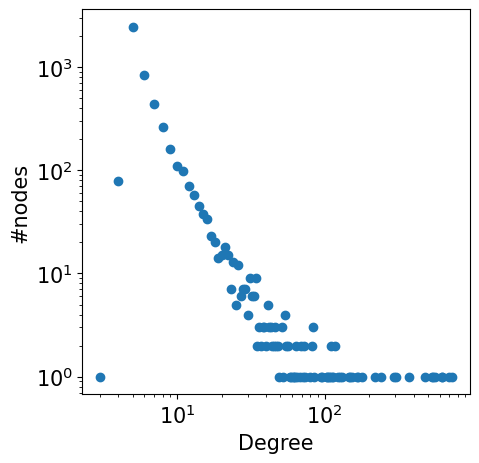

In [30]:
represent_degree_distribution(G3, scale='log',rep='scatter')

#### Network 4:

No self loops found.
No duplicated edges found.
           Number of Nodes  Number of Edges  Min Degree  Max Degree  \
network 4             5000            24975           5         210   

           Average Degree  Average Clustering Coefficient  \
network 4            9.99                        0.010729   

           Degree Assortativity  Average Path Length  Diameter  
network 4             -0.032451             3.486817         5  


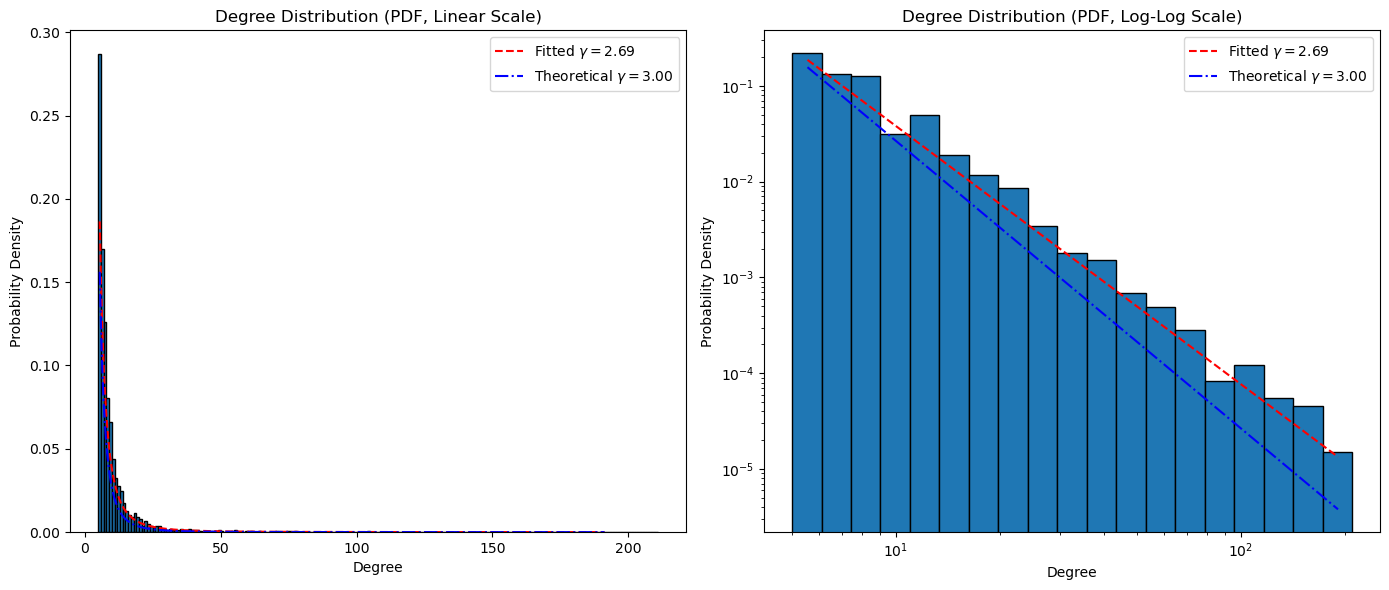

,Number of Nodes,Number of Edges,Min Degree,Max Degree,Average Degree,Average Clustering Coefficient,Degree Assortativity,Average Path Length,Diameter
network 4,5000,24975,5,210,9.99,0.010729,-0.032451,3.486817,5


In [31]:
network4_path = os.path.join(DATASET_PATH, "net4.net")
metrics_df4 = analyze_network_macroscopic(network4_path, "network 4",gamma=True)
metrics_df4

Single plot for latex report

No self loops found.
No duplicated edges found.


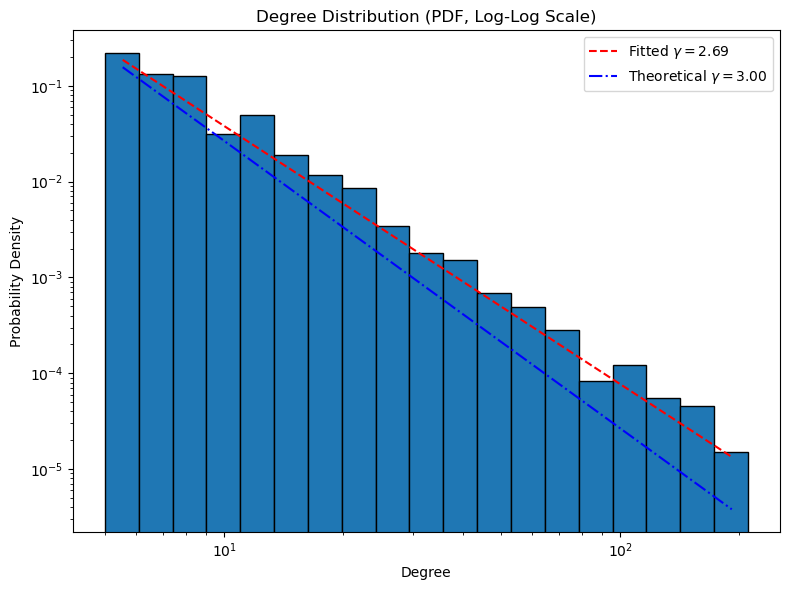

In [32]:
G4 = read_network(network4_path)
plot_degree_distributions(G4, plot_type='loglog',use_cdf=False,gamma=True)

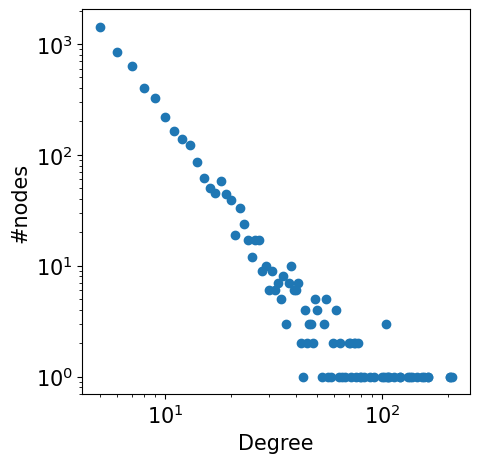

In [33]:
represent_degree_distribution(G4, scale='log',rep='scatter')

## Microscopic Analysis

### Computing Node Centralities
This cell defines a function `compute_centrality_measures` which calculates different centrality measures using built-in NetworkX functions: - PageRank - Eigenvector Centrality - Betweenness Centrality - Closeness Centrality The function then identifies the top 5 nodes for each centrality metric and prints the results.

In [53]:
def compute_centrality_measures(G):
    """
    Computes several node centralities and prints a formatted table showing the top 5 nodes for each metric.
    
    Centrality metrics computed:
      - PageRank
      - Eigenvector Centrality
      - Betweenness Centrality
      - Closeness Centrality
      
    Parameters:
        G (nx.Graph or nx.DiGraph): The networkx graph.
        
    Returns:
        centralities (dict): Dictionary containing centrality dictionaries for each metric.
    """
    # Compute centralities
    page_rank = nx.pagerank(G)
    eigenvector = nx.eigenvector_centrality(G, max_iter=1000)
    betweenness = nx.betweenness_centrality(G)
    closeness = nx.closeness_centrality(G)
    
    centralities = {
        "PageRank": page_rank,
        "Eigenvector": eigenvector,
        "Betweenness": betweenness,
        "Closeness": closeness
    }
    
    # Function to get top n nodes sorted by centrality score
    def top_n(centrality_dict, n=5):
        return sorted(centrality_dict.items(), key=lambda item: item[1], reverse=True)[:n]
    
    # For each centrality metric, prepare and print a separate table
    for metric, centrality in centralities.items():
        top_nodes = top_n(centrality)
        table_data = []
        for rank, (node, score) in enumerate(top_nodes, start=1):
            table_data.append([rank, node, score])
        headers = ["Rank", "Node", "Score"]
        print(f"\n{metric} Centrality:")
        print(tabulate(table_data, headers=headers, tablefmt="fancy_grid", floatfmt=".4f"))
    
    return centralities

def analyze_network_microscopic(filepath):
    """
    Analyzes the microscopic properties of a network by reading the network and computing metrics.
    
    Parameters:
        filepath (str): Path to the .net file.
        
    Returns:
        metrics_df (pd.DataFrame): DataFrame with the computed metrics.
    """
    # Read the network (assuming a function read_network is defined)
    G = read_network(filepath)
    
    # Compute network metrics
    metrics_df = compute_centrality_measures(G)
    
    return metrics_df



### Network 1

In [54]:
centrality_measures = analyze_network_microscopic(network1_path)

No self loops found.
No duplicated edges found.

PageRank Centrality:
╒════════╤════════╤═════════╕
│   Rank │   Node │   Score │
╞════════╪════════╪═════════╡
│      1 │   1693 │  0.0003 │
├────────┼────────┼─────────┤
│      2 │   1579 │  0.0003 │
├────────┼────────┼─────────┤
│      3 │   4891 │  0.0003 │
├────────┼────────┼─────────┤
│      4 │    651 │  0.0003 │
├────────┼────────┼─────────┤
│      5 │   3659 │  0.0003 │
╘════════╧════════╧═════════╛

Eigenvector Centrality:
╒════════╤════════╤═════════╕
│   Rank │   Node │   Score │
╞════════╪════════╪═════════╡
│      1 │    651 │  0.0286 │
├────────┼────────┼─────────┤
│      2 │   1937 │  0.0265 │
├────────┼────────┼─────────┤
│      3 │   4526 │  0.0256 │
├────────┼────────┼─────────┤
│      4 │   4398 │  0.0253 │
├────────┼────────┼─────────┤
│      5 │   1939 │  0.0252 │
╘════════╧════════╧═════════╛

Betweenness Centrality:
╒════════╤════════╤═════════╕
│   Rank │   Node │   Score │
╞════════╪════════╪═════════╡
│      1 │

### Network 2

In [55]:
centrality_measures = analyze_network_microscopic(network2_path)

No self loops found.
No duplicated edges found.

PageRank Centrality:
╒════════╤════════╤═════════╕
│   Rank │   Node │   Score │
╞════════╪════════╪═════════╡
│      1 │   1581 │  0.0004 │
├────────┼────────┼─────────┤
│      2 │    787 │  0.0004 │
├────────┼────────┼─────────┤
│      3 │   1990 │  0.0004 │
├────────┼────────┼─────────┤
│      4 │   2372 │  0.0004 │
├────────┼────────┼─────────┤
│      5 │     52 │  0.0004 │
╘════════╧════════╧═════════╛

Eigenvector Centrality:
╒════════╤════════╤═════════╕
│   Rank │   Node │   Score │
╞════════╪════════╪═════════╡
│      1 │   1581 │  0.0412 │
├────────┼────────┼─────────┤
│      2 │   3233 │  0.0343 │
├────────┼────────┼─────────┤
│      3 │    787 │  0.0341 │
├────────┼────────┼─────────┤
│      4 │   2375 │  0.0337 │
├────────┼────────┼─────────┤
│      5 │    131 │  0.0335 │
╘════════╧════════╧═════════╛

Betweenness Centrality:
╒════════╤════════╤═════════╕
│   Rank │   Node │   Score │
╞════════╪════════╪═════════╡
│      1 │

### Network 3

In [56]:
centrality_measures = analyze_network_microscopic(network3_path)

No duplicated edges found.

PageRank Centrality:
╒════════╤════════╤═════════╕
│   Rank │   Node │   Score │
╞════════╪════════╪═════════╡
│      1 │      5 │  0.0136 │
├────────┼────────┼─────────┤
│      2 │      7 │  0.0128 │
├────────┼────────┼─────────┤
│      3 │      2 │  0.0116 │
├────────┼────────┼─────────┤
│      4 │      0 │  0.0115 │
├────────┼────────┼─────────┤
│      5 │      6 │  0.0102 │
╘════════╧════════╧═════════╛

Eigenvector Centrality:
╒════════╤════════╤═════════╕
│   Rank │   Node │   Score │
╞════════╪════════╪═════════╡
│      1 │      5 │  0.2592 │
├────────┼────────┼─────────┤
│      2 │      7 │  0.2417 │
├────────┼────────┼─────────┤
│      3 │      2 │  0.2254 │
├────────┼────────┼─────────┤
│      4 │      0 │  0.2254 │
├────────┼────────┼─────────┤
│      5 │      3 │  0.2070 │
╘════════╧════════╧═════════╛

Betweenness Centrality:
╒════════╤════════╤═════════╕
│   Rank │   Node │   Score │
╞════════╪════════╪═════════╡
│      1 │      5 │  0.1378 │
├

### Network 4

In [57]:
centrality_measures = analyze_network_microscopic(network4_path)

No self loops found.
No duplicated edges found.

PageRank Centrality:
╒════════╤════════╤═════════╕
│   Rank │   Node │   Score │
╞════════╪════════╪═════════╡
│      1 │      6 │  0.0036 │
├────────┼────────┼─────────┤
│      2 │      0 │  0.0035 │
├────────┼────────┼─────────┤
│      3 │      9 │  0.0035 │
├────────┼────────┼─────────┤
│      4 │     10 │  0.0028 │
├────────┼────────┼─────────┤
│      5 │      8 │  0.0028 │
╘════════╧════════╧═════════╛

Eigenvector Centrality:
╒════════╤════════╤═════════╕
│   Rank │   Node │   Score │
╞════════╪════════╪═════════╡
│      1 │      6 │  0.2239 │
├────────┼────────┼─────────┤
│      2 │      0 │  0.2234 │
├────────┼────────┼─────────┤
│      3 │      9 │  0.2062 │
├────────┼────────┼─────────┤
│      4 │      8 │  0.1741 │
├────────┼────────┼─────────┤
│      5 │      3 │  0.1686 │
╘════════╧════════╧═════════╛

Betweenness Centrality:
╒════════╤════════╤═════════╕
│   Rank │   Node │   Score │
╞════════╪════════╪═════════╡
│      1 │

# Part 2: Models

### Model Verification


In this section, we compute additional metrics to validate the models hypothesized from the previous analysis.

In [9]:
def infer_parameters(G, model):
    """
    Infer the parameters required to generate a synthetic network based on the hypothesized model.
    
    Parameters:
      - For ER: p = (2E)/(N*(N-1))
      - For WS: k (approximated from average degree, rounded to even) and beta (defaulted to 0.1)
      - For BA: m is taken as round(avg_degree/2) with a minimum of 1
      - For CM: use the degree sequence from G
    """
    params = {}
    N = G.number_of_nodes()
    E = G.number_of_edges()
    degrees = [d for _, d in G.degree()]
    avg_degree = np.mean(degrees)
    
    if model.lower() == 'er':
        p = (2 * E) / (N * (N - 1))
        params['p'] = p
    elif model.lower() == 'ws':
        k = int(round(avg_degree))
        # Ensure k is even and at least 2 (WS requires an even number of neighbors)
        if k % 2 == 1:
            k += 1
        if k < 2:
            k = 2
        beta = 0.1  # A default rewiring probability; could be estimated if desired.
        params['k'] = k
        params['beta'] = beta
    elif model.lower() == 'ba':
        m = max(1, int(round(avg_degree / 2)))
        params['m'] = m
    elif model.lower() == 'cm':
        # For the configuration model, we need the degree sequence
        params['degree_sequence'] = [d for _, d in G.degree()]
    else:
        raise ValueError("Model not recognized. Please choose one of: er, ws, ba, cm")
        
    
    params['N'] = N
    return params

def generate_synthetic_network(model, params):
    """
    Generate a synthetic network given the model type and inferred parameters.
    
    Returns a NetworkX graph.
    """
    N = params['N']
    if model.lower() == 'er':
        p = params['p']
        G = nx.erdos_renyi_graph(N, p)
    elif model.lower() == 'ws':
        k = params['k']
        beta = params['beta']
        G = nx.watts_strogatz_graph(N, k, beta)
    elif model.lower() == 'ba':
        m = params['m']
        # BA requires m < N; ensure this condition
        if m >= N:
            m = N - 1
        G = nx.barabasi_albert_graph(N, m)
    elif model.lower() == 'cm':
        degree_sequence = params['degree_sequence']
        # The configuration model may create self-loops and parallel edges; we remove them.
        G = nx.configuration_model(degree_sequence)
        G = nx.Graph(G)  # Remove parallel edges
        G.remove_edges_from(nx.selfloop_edges(G))
    else:
        raise ValueError("Unknown model type provided.")
    
    return G

def test_hypothesis(file, model, repetitions,graph_name):
    G_data = read_network(file)
    data_metrics = compute_network_metrics(G_data, graph_name)
    
    print(f"Loaded network from '{file}' with {G_data.number_of_nodes()} nodes and {G_data.number_of_edges()} edges.")
    
    # Compute and display metrics for the original (data) network
    data_metrics = compute_network_metrics(G_data, graph_name)
    print("\nData Network Metrics:")
    for key, value in data_metrics.iloc[0].items():
        print(f"  {key}: {value}")
        
    # Infer generation parameters from the data network
    params = infer_parameters(G_data, model)
    print(f"\nInferred parameters for the {model.upper()} model:")
    for key, value in params.items():
        print(f"  {key}: {value}")
        
    # Generate synthetic networks and collect their metrics
    synthetic_metrics = []
    for i in range(repetitions):
        print(f"Generating synthetic network {i+1}/{repetitions}...")
        G_synth = generate_synthetic_network(model, params)
        metrics = compute_network_metrics(G_synth,graph_name)
        synthetic_metrics.append(metrics)
    
    # Aggregate metrics: compute mean and standard deviation for each metric
    aggregated = {}
    metric_keys = synthetic_metrics[0].keys()
    for key in metric_keys:
        values = [m.iloc[0][key] for m in synthetic_metrics if not np.isnan(m.iloc[0][key])]
        aggregated[key] = {'mean': np.mean(values), 'std': np.std(values)}
    
    print(f"\nSynthetic Network Metrics (averaged over {repetitions} repetitions):")
    for key, stats in aggregated.items():
        print(f"  {key}: mean = {stats['mean']:.4f}, std = {stats['std']:.4f}")
        
    # Comparison summary between data and synthetic networks
    print("\nComparison between data and synthetic network metrics:")
    for key in data_metrics.keys():
        data_val = data_metrics.iloc[0][key]
        synth_mean = aggregated[key]['mean']
        synth_std = aggregated[key]['std']
        print(f"  {key}: Data = {data_val:.4f} | Synthetic = {synth_mean:.4f} ± {synth_std:.4f}")

# network4_path = os.path.join(DATASET_PATH, "net4.net")
# test_hypothesis(network4_path, "ba", 2, "Network 4")

#### Network 1


In [10]:
network1_path = os.path.join(DATASET_PATH, "net1.net")
test_hypothesis(network1_path, "ws", 20, "Network 1")

No self loops found.
No duplicated edges found.
Loaded network from '..\Datasets\net1.net' with 5000 nodes and 25000 edges.

Data Network Metrics:
  Number of Nodes: 5000.0
  Number of Edges: 25000.0
  Min Degree: 6.0
  Max Degree: 16.0
  Average Degree: 10.0
  Average Clustering Coefficient: 0.41407024198024145
  Degree Assortativity: -0.00973282948611821
  Average Path Length: 5.121124624924985
  Diameter: 8.0

Inferred parameters for the WS model:
  k: 10
  beta: 0.1
  N: 5000
Generating synthetic network 1/20...
Generating synthetic network 2/20...
Generating synthetic network 3/20...
Generating synthetic network 4/20...
Generating synthetic network 5/20...
Generating synthetic network 6/20...
Generating synthetic network 7/20...
Generating synthetic network 8/20...
Generating synthetic network 9/20...
Generating synthetic network 10/20...
Generating synthetic network 11/20...
Generating synthetic network 12/20...
Generating synthetic network 13/20...
Generating synthetic network 1

#### Network 2


In [11]:
network2_path = os.path.join(DATASET_PATH, "net2.net")
test_hypothesis(network2_path, "er", 20, "Network 2")

No self loops found.
No duplicated edges found.
Loaded network from '..\Datasets\net2.net' with 5000 nodes and 24873 edges.

Data Network Metrics:
  Number of Nodes: 5000.0
  Number of Edges: 24873.0
  Min Degree: 1.0
  Max Degree: 24.0
  Average Degree: 9.9492
  Average Clustering Coefficient: 0.002099483091727676
  Degree Assortativity: -0.005662570648240358
  Average Path Length: 3.956049529905981
  Diameter: 7.0

Inferred parameters for the ER model:
  p: 0.001990238047609522
  N: 5000
Generating synthetic network 1/20...
Generating synthetic network 2/20...
Generating synthetic network 3/20...
Generating synthetic network 4/20...
Generating synthetic network 5/20...
Generating synthetic network 6/20...
Generating synthetic network 7/20...
Generating synthetic network 8/20...
Generating synthetic network 9/20...
Generating synthetic network 10/20...
Generating synthetic network 11/20...
Generating synthetic network 12/20...
Generating synthetic network 13/20...
Generating synthetic

#### Network 3


In [12]:
network3_path = os.path.join(DATASET_PATH, "net3.net")
test_hypothesis(network3_path, "cm", 20, "Network 3")

No duplicated edges found.
Loaded network from '..\Datasets\net3.net' with 5000 nodes and 23508 edges.

Data Network Metrics:
  Number of Nodes: 5000.0
  Number of Edges: 23508.0
  Min Degree: 3.0
  Max Degree: 732.0
  Average Degree: 9.4032
  Average Clustering Coefficient: 0.08621412906957482
  Degree Assortativity: -0.1338595315237447
  Average Path Length: 3.0082426885377074
  Diameter: 5.0

Inferred parameters for the CM model:
  degree_sequence: [620, 295, 626, 543, 533, 732, 555, 691, 51, 476, 153, 107, 71, 46, 43, 126, 168, 372, 241, 22, 114, 302, 148, 15, 82, 220, 112, 111, 178, 35, 18, 72, 64, 72, 96, 26, 29, 54, 111, 62, 43, 83, 45, 145, 55, 73, 69, 48, 11, 104, 124, 68, 9, 82, 24, 38, 103, 14, 46, 38, 37, 117, 24, 32, 13, 54, 39, 64, 12, 34, 48, 32, 10, 20, 17, 14, 55, 108, 130, 32, 34, 5, 56, 34, 52, 65, 18, 23, 29, 34, 16, 58, 165, 5, 8, 54, 26, 21, 8, 32, 56, 12, 19, 85, 95, 21, 41, 26, 12, 20, 20, 31, 28, 11, 8, 22, 16, 35, 69, 117, 33, 39, 30, 21, 13, 83, 24, 41, 16, 4

#### Network 4


In [13]:
network4_path = os.path.join(DATASET_PATH, "net4.net")
test_hypothesis(network4_path, "ba", 20, "Network 4")

No self loops found.
No duplicated edges found.
Loaded network from '..\Datasets\net4.net' with 5000 nodes and 24975 edges.

Data Network Metrics:
  Number of Nodes: 5000.0
  Number of Edges: 24975.0
  Min Degree: 5.0
  Max Degree: 210.0
  Average Degree: 9.99
  Average Clustering Coefficient: 0.010728673698751334
  Degree Assortativity: -0.032450672101984074
  Average Path Length: 3.4868165633126624
  Diameter: 5.0

Inferred parameters for the BA model:
  m: 5
  N: 5000
Generating synthetic network 1/20...
Generating synthetic network 2/20...
Generating synthetic network 3/20...
Generating synthetic network 4/20...
Generating synthetic network 5/20...
Generating synthetic network 6/20...
Generating synthetic network 7/20...
Generating synthetic network 8/20...
Generating synthetic network 9/20...
Generating synthetic network 10/20...
Generating synthetic network 11/20...
Generating synthetic network 12/20...
Generating synthetic network 13/20...
Generating synthetic network 14/20...
G

## Network 5 Visualization

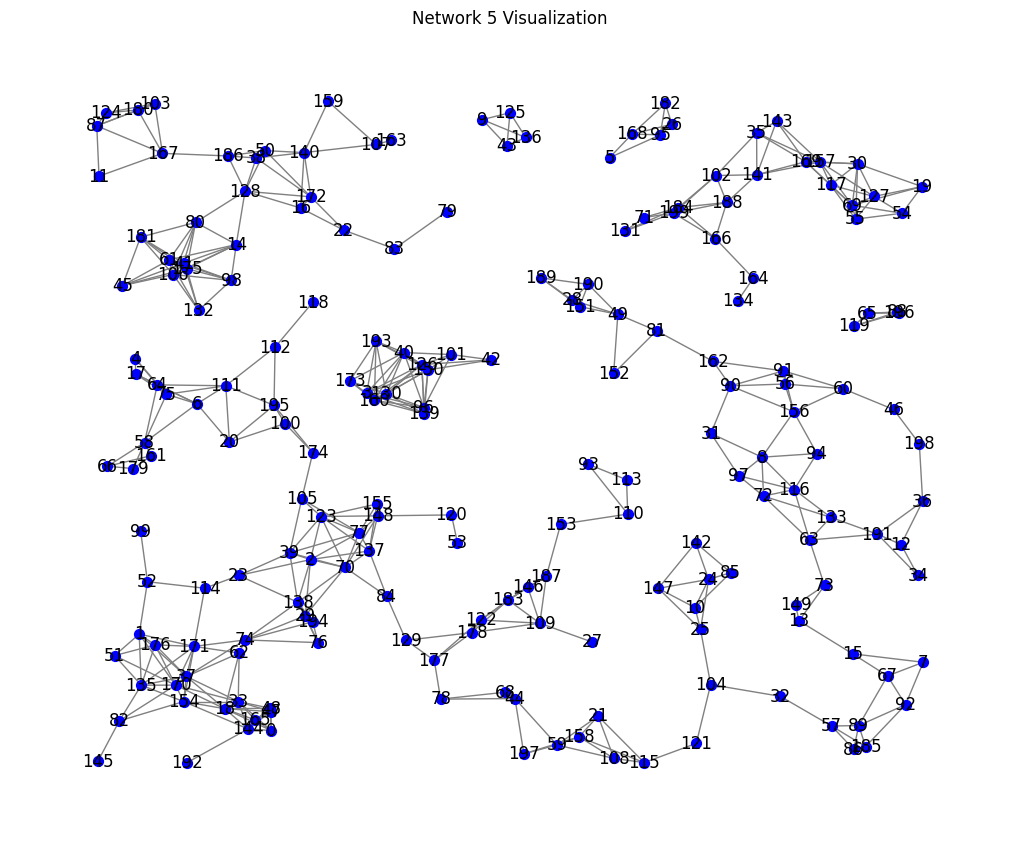

In [ ]:
# Read the network
network_path = os.path.join(DATASET_PATH, "net5.net")
G_net5 = read_network(network_path)

# Read the positions from the file
positions_net5 = {}
positions_net5_path = os.path.join(DATASET_PATH, "positions_net5.txt")
with open(positions_net5_path, "r") as f:
    next(f)  # Skip the first line (header)
    for line in f:
        node, x, y = line.strip().split()
        positions_net5[node] = (float(x), float(y))

# Plot the network
plt.figure(figsize=(10, 8))
nx.draw(G_net5, pos=positions_net5, with_labels=True, node_size=50, node_color='blue', edge_color='gray')
plt.title("Network 5 Visualization")
plt.show()

#### Validate Model:

To validate the hypothesis that nodes are connected based on spatial proximity under a threshold distance \( r \), we follow these steps:

1. **Compute Distance Between All Pairs**  
   We calculate the Euclidean distance for every pair of nodes in the network.

2. **Identify Key Distances**  
   - Find the **maximum distance** between nodes that are connected in the original network ($ b $).  
   - Find the **minimum distance** between nodes that are not connected in the original network ($ a $).  
   - Compute the middle value as:  
     $$ r = \frac{a + b}{2} $$
     which serves as the connection threshold.

3. **Reconstruct the Network**  
   Using this threshold $ r $, we create a new graph where an edge exists between two nodes if their Euclidean distance is at most $ r $.

4. **Compare Original vs. Reconstructed Network**  
   - Compute the number of overlapping edges.
   - Calculate key similarity metrics:
     - **Jaccard Similarity**: Measures the fraction of common edges between both graphs.
       $$ J = \frac{|E_{\text{original}} \cap E_{\text{reconstructed}}|}{|E_{\text{original}} \cup E_{\text{reconstructed}}|} $$
     - **Recall**: The fraction of original edges correctly reconstructed.
       $$ R = \frac{|E_{\text{original}} \cap E_{\text{reconstructed}}|}{|E_{\text{original}}|} $$
     - **Precision**: The fraction of reconstructed edges that match the original graph.
       $$ P = \frac{|E_{\text{original}} \cap E_{\text{reconstructed}}|}{|E_{\text{reconstructed}}|} $$

By evaluating these metrics, we can determine how well a simple spatial distance-based model explains the observed network structure.






In [ ]:
# Compute distances for all pairs
connected_distances = []
disconnected_distances = []

nodes = list(G_net5.nodes())

for u, v in itertools.combinations(nodes, 2):
    x1, y1 = positions_net5[u]
    x2, y2 = positions_net5[v]
    dist = math.sqrt((x1 - x2)**2 + (y1 - y2)**2)
    
    if G_net5.has_edge(u, v):
        connected_distances.append(dist)
    else:
        disconnected_distances.append(dist)

# Find max distance among connected nodes and min distance among disconnected nodes
max_connected = max(connected_distances)
min_disconnected = min(disconnected_distances)
threshold = 0.5 * (max_connected + min_disconnected)

print(f"Max distance among connected nodes: {max_connected:.4f}")
print(f"Min distance among disconnected nodes: {min_disconnected:.4f}")
print(f"Chosen threshold (midpoint): {threshold:.4f}")

# Reconstruct a graph based on this threshold
G_reconstructed = nx.Graph()
G_reconstructed.add_nodes_from(G_net5.nodes())

for u, v in itertools.combinations(nodes, 2):
    x1, y1 = positions_net5[u]
    x2, y2 = positions_net5[v]
    dist = math.sqrt((x1 - x2)**2 + (y1 - y2)**2)
    if dist <= threshold:
        G_reconstructed.add_edge(u, v)

# Compute overlap between original and reconstructed edges
edges_net5 = set(map(lambda e: tuple(sorted(e)), G_net5.edges()))
edges_rec = set(map(lambda e: tuple(sorted(e)), G_reconstructed.edges()))

overlap = edges_net5.intersection(edges_rec)
overlap_size = len(overlap)
union_size = len(edges_net5.union(edges_rec))

jaccard = overlap_size / union_size if union_size > 0 else 0
recall = overlap_size / len(edges_net5) if len(edges_net5) > 0 else 0
precision = overlap_size / len(edges_rec) if len(edges_rec) > 0 else 0

print(f"Number of overlapping edges: {overlap_size}")
print(f"Jaccard similarity (overlap/union): {jaccard:.4f}")
print(f"Recall (overlap/original): {recall:.4f}")
print(f"Precision (overlap/reconstructed): {precision:.4f}")


Max distance among connected nodes: 0.0900
Min distance among disconnected nodes: 0.0903
Chosen threshold (midpoint): 0.0901
Number of overlapping edges: 465
Jaccard similarity (overlap/union): 1.0000
Recall (overlap/original): 1.0000
Precision (overlap/reconstructed): 1.0000
